In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping

scaler = MinMaxScaler()

In [2]:
df = pd.read_csv("../Data/train_preprocessed.csv", low_memory=False)

features = ["Num_of_Loan", "Num_of_Delayed_Payment", "Interest_Rate", 'Annual_Income']
X = df[features].to_numpy()

y = df["Credit_Score"].to_numpy()

In [3]:
X = scaler.fit_transform(X)

# Feature Selection with:
1. Mutual Information 
2. PCA
3. Gini (non quella di H.P.)
4. Random Forest (information Gain)

In [27]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

mutual_info_classif(df, y_norm)
#mutual_info_regression(df.to_numpy()[:, 3:-1], y_norm)

ValueError: could not convert string to float: 'CUS_0xd40'

In [20]:
[col for col in df.columns if col not in features]

['Customer_ID',
 'Month',
 'Age',
 'Occupation',
 'Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Type_of_Loan',
 'Delay_from_due_date',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Credit_Mix',
 'Outstanding_Debt',
 'Credit_Utilization_Ratio',
 'Credit_History_Age',
 'Payment_of_Min_Amount',
 'Total_EMI_per_month',
 'Amount_invested_monthly',
 'Payment_Behaviour',
 'Monthly_Balance',
 'Credit_Score']

In [5]:
df[features].describe()

,Num_of_Loan,Num_of_Delayed_Payment,Interest_Rate,Annual_Income
count,53335.000000,53335.000000,53335.000000,5.333500e+04
mean,3.896184,31.860486,14.900066,1.577983e+14
std,2.240140,231.366659,8.883739,1.135423e+15
min,1.000000,0.000000,1.000000,7.080700e+04
25%,2.000000,9.000000,8.000000,1.790801e+06
50%,4.000000,14.000000,14.000000,3.708598e+06
75%,5.000000,18.000000,20.000000,8.147196e+06
max,49.000000,4397.000000,100.000000,1.345963e+16


In [22]:
le = LabelEncoder()
le.fit(y)

y_norm = le.transform(y)

In [7]:
mask = np.any(X>0, axis=1)
X = X[mask]
y_norm = y_norm[mask]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size=0.2)

In [9]:
n_input = X.shape[-1]
n_output = np.unique(y_norm).size

In [10]:
Arch = [
    Dense(units=n_input, activation='relu'),
    Dense(units=n_output, activation='linear')
]

model = Sequential(Arch)

In [11]:
opt = Adam(learning_rate=0.01)

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=opt)

In [12]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
1067/1067 [==============================] - 1s 956us/step - loss: 0.8733 - val_loss: 0.8543
Epoch 2/100
1067/1067 [==============================] - 1s 882us/step - loss: 0.8525 - val_loss: 0.8523
Epoch 3/100
1067/1067 [==============================] - 1s 832us/step - loss: 0.8523 - val_loss: 0.8600
Epoch 4/100
1067/1067 [==============================] - 1s 836us/step - loss: 0.8518 - val_loss: 0.8549
Epoch 5/100
1067/1067 [==============================] - 1s 840us/step - loss: 0.8517 - val_loss: 0.8518
Epoch 6/100
1067/1067 [==============================] - 1s 830us/step - loss: 0.8518 - val_loss: 0.8522
Epoch 7/100
1067/1067 [==============================] - 1s 830us/step - loss: 0.8515 - val_loss: 0.8514
Epoch 8/100
1067/1067 [==============================] - 1s 848us/step - loss: 0.8515 - val_loss: 0.8551
Epoch 9/100
1067/1067 [==============================] - 1s 838us/step - loss: 0.8516 - val_loss: 0.8545
Epoch 10/100
1067/1067 [==============================]

In [13]:
logits = model(X_train)
f_X = tensorflow.nn.softmax(logits)

In [14]:
y_hat = np.argmax(f_X, axis=1)

In [15]:
np.unique(np.argmax(f_X, axis=1), return_counts=1)

(array([0, 1, 2], dtype=int64), array([ 2740,  9768, 30160], dtype=int64))

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
print(classification_report(y_train, y_hat))

              precision    recall  f1-score   support

           0       0.47      0.18      0.26      7161
           1       0.65      0.49      0.56     12944
           2       0.60      0.81      0.69     22563

    accuracy                           0.61     42668
   macro avg       0.57      0.49      0.50     42668
weighted avg       0.59      0.61      0.58     42668



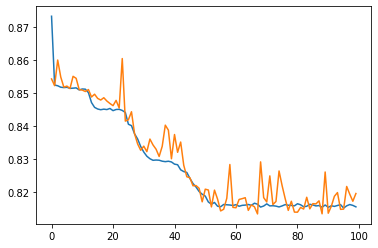

In [18]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
#plt.xlim(20,100)